In [12]:
!git clone 'https://github.com/Lorenz92/SKADC1.git'
% cd SKADC1
!echo $PWD

Cloning into 'SKADC1'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 17), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [17]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os

import src.dataset as dataset
import src.config as config
from src.utils import *
import src.preprocessing as prep
import src.models as models

# from src.config import * 

%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
for download_info in config.required_files:
    if not os.path.exists(os.path.join(config.TRAIN_DATA_FOLDER, download_info['file_name'])):
        download_data(download_info['file_name'], download_info['url'], config.DOWNLOAD_FOLDER)

Download completed!
Download completed!


In [112]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH, subset=config.DATA_SUBSET)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


In [113]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
# data_560Mhz_1000h_fits.info()
data_560Mhz_1000h_fits.filename()

# print(data_560Mhz_1000h_fits[0].data)
# print(data_560Mhz_1000h_fits[0].data.shape)

data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]


In [28]:
# Visualization test
from astropy.io import fits
from astropy.utils.data import download_file

# image_file = download_file('https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download', cache=True )

# image_data = fits.getdata(image_file)
# image_data = image_data.reshape(image_data.shape[2:])

# compute per value to clip the image
perc = 99.9
percentileThresh = np.percentile(data_560Mhz_1000h, perc)
print (f'{perc} percentile {percentileThresh}')

# # crop the image to speed up computation and clip using per value
# image_crop= image_data[5000:10000, 5000:10000]
# image_crop.clip(max=percentileThresh)

# plt.figure(figsize=(100, 100))
# # plt.imshow(normalized_data, cmap='viridis', vmax=255, vmin=0)
# for idx in range(25):
#     plt.subplot(5, 5, idx+1)
#     plt.axis('off')
#     base = 200 * idx
#     end = base + 200
#     normalized_data = image_crop[base:end, base:end] * (1.0 / percentileThresh)
#     plt.imshow(normalized_data, cmap='viridis', vmax=1, vmin=0)

99.9 percentile 8.316711500810925e-06


### Preprocessing

In [116]:
coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header)

In [5]:
pd.DataFrame.from_dict(coords)

,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,18019.631633,18181.823147,18020.999232,18182.360119,0.700870,0.220108,6.050027,1.367598,0.536972
4,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358
...,...,...,...,...,...,...,...,...,...
19217,17592.572752,16742.936603,17593.009233,16743.428821,0.319405,0.078610,0.853117,0.436482,0.492218
19218,18658.822580,18666.464880,18659.100383,18666.968994,0.276376,0.080265,1.127797,0.277803,0.504113
19219,17523.170058,16995.697610,17523.352636,16995.761662,0.093504,0.024824,-0.226387,0.182578,0.064053
19220,16950.523810,17747.923087,16950.979337,17748.452311,0.264791,0.227555,-1.498732,0.455528,0.529224


In [117]:
df_train = ska_dataset._extend_dataframe(ska_dataset.raw_train_df, coords)
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17712.942,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17160.919,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18506.577,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18182.095,18019.631633,18181.823147,18020.999232,18182.360119,0.700870,0.220108,6.050027,1.367598,0.536972
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18600.680,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358


In [118]:
x1_min = int(np.floor(min(df_train['x1'])))
y1_min = int(np.floor(min(df_train['y1'])))

x2_max = int(np.floor(max(df_train['x2'])))
y2_max = int(np.floor(max(df_train['y2'])))

data_560Mhz_1000h_train = data_560Mhz_1000h[y1_min:y2_max, x1_min:x2_max]
data_560Mhz_1000h_train.shape


(3187, 3491)

(array([1.704e+03, 4.870e+02, 2.400e+02, 1.060e+02, 2.700e+01, 2.100e+01,
        1.500e+01, 8.000e+00, 6.000e+00, 2.000e+00, 5.000e+00, 5.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([1.0000e-04, 2.4750e-04, 3.9500e-04, 5.4250e-04, 6.9000e-04,
        8.3750e-04, 9.8500e-04, 1.1325e-03, 1.2800e-03, 1.4275e-03,
        1.5750e-03, 1.7225e-03, 1.8700e-03, 2.0175e-03, 2.1650e-03,
        2.3125e-03, 2.4600e-03, 2.6075e-03, 2.7550e-03, 2.9025e-03,
        3.0500e-03, 3.1975e-03, 3.3450e-03, 3.4925e-03, 3.6400e-03,
        3.7875e-03, 3.9350e-03, 4.0825e-03, 4.2300e-03, 4.3775e-03,
        4.5250e-03, 4.6725e-03, 4.8200e-03, 4.9675e-03, 5.1150e-03,
        5.2625e-03, 5.4100

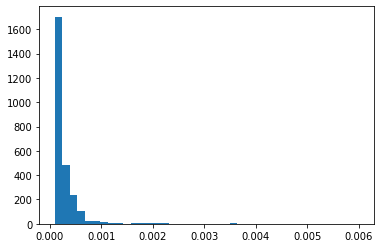

In [127]:
# histogram of noise (- noise, + noise)
# we know that negative values are due to noise, and we assume a gaussian noise distribution

data_flat = data_560Mhz_1000h_train.flatten()
min_val = min(data_flat)
plt.hist(data_flat, bins = 40, range = (0.0001, 0.006))#abs(min_val)))

In [8]:
fits_max_data_560Mhz_1000h = np.max(data_560Mhz_1000h)
print(fits_max_data_560Mhz_1000h)

data_560Mhz_1000h_train_clipped = np.clip(data_560Mhz_1000h_train, a_min=0, a_max=fits_max_data_560Mhz_1000h)

# NB the computation of the mean val must be after the noise removal
data_flat = data_560Mhz_1000h_train_clipped.flatten()
mean_GLval = statistics.mean(data_flat)
max_GLval = max(data_flat)
min_GLval = min(data_flat)
print(mean_GLval)
print(max_GLval)
print(min_GLval)

0.48094657


In [10]:
data_560Mhz_1000h_train_clipped

array([[0.0000000e+00, 5.0277004e-07, 8.1352823e-07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 4.7234460e-07, 7.5504875e-07, ..., 0.0000000e+00,
        0.0000000e+00, 1.5155882e-07],
       [0.0000000e+00, 0.0000000e+00, 4.7753889e-07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 3.2216460e-07, 2.1111914e-07, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        4.3899996e-07, 6.1143220e-07]], dtype=float32)

In [9]:
patches={}
patches = ska_dataset._split_in_patch(data_560Mhz_1000h_train_clipped, df_train, data_560Mhz_1000h_fits.filename(), x1_min, y1_min, 205) # Remember to remove internal return

image saved
Index(['ID', 'RA (core)', 'DEC (core)', 'RA (centroid)', 'DEC (centroid)',
       'FLUX', 'Core frac', 'BMAJ', 'BMIN', 'PA', 'SIZE', 'CLASS', 'SELECTION',
       'x', 'y', 'x1', 'y1', 'x2', 'y2', 'major_semia_px', 'minor_semia_px',
       'pa_in_rad', 'width', 'height', 'x1s', 'y1s', 'x2s', 'y2s',
       'patch_name', 'patch_xo', 'patch_yo', 'patch_dim'],
      dtype='object')
         ID  RA (core)  DEC (core)  RA (centroid)  DEC (centroid)      FLUX  \
0  27514971  -0.014459  -29.933004      -0.014121      -29.932705  0.039324   
1  15252327  -0.039005  -29.915081      -0.039002      -29.915081  0.000010   
2  13302538  -0.005224  -29.939449      -0.005224      -29.939449  0.000017   
3  30994188  -0.035645  -29.910868      -0.035645      -29.910868  0.000934   
4  29158240  -0.002566  -29.917469      -0.002566      -29.917469  0.000036   

   Core frac    BMAJ    BMIN       PA  ...      width     height         x1s  \
0   0.004216  31.508  17.616  353.308  ...  51.900100

In [6]:
# test if file has been correctly saved

patch = '0_1638016380_205.npy'
pkl = '0_1638016380_205.pkl'

path = os.path.join(config.TRAIN_PATCHES_FOLDER, '0_1638016380_205/')
p = np.load(os.path.join(path, patch))
pdata = pd.read_pickle(os.path.join(path, pkl))
print(p)
print(pdata)

[[0.0000000e+00 5.0277004e-07 8.1352823e-07 ... 2.1992520e-07
  3.3757752e-07 8.9618879e-08]
 [0.0000000e+00 4.7234460e-07 7.5504875e-07 ... 0.0000000e+00
  2.7678368e-08 3.8842813e-08]
 [0.0000000e+00 0.0000000e+00 4.7753889e-07 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.6627402e-07 2.2166087e-07 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.3635220e-07 2.9386493e-07 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
          ID  RA (core)  DEC (core)  RA (centroid)  DEC (centroid)      FLUX  \
0   27514971  -0.014459  -29.933004      -0.014121      -29.932705  0.039324   
1   15252327  -0.039005  -29.915081      -0.039002      -29.915081  0.000010   
2   13302538  -0.005224  -29.939449      -0.005224      -29.939449  0.000017   
3   30994188  -0.035645  -29.910868      -0.035645      -29.910868  0.000934   
4   29158240  -0.002566  -29.917469 

#TODO:
- Ingrandire bbox
- unire bbox sovrapposte
- Mergiare branch data_clean (anche alla fine)
- Quando vengono create le patch, ritagliare le bbox per farle stare tutte nella patch X
- Check tra nostro dataset pulito e quello di ICRAR (dopo aver mergiato il branch data_clean)

Da capire per la rete:
- bisogna scalre input tra 0 e 255 intero?
- salvare le patch come immagini o possiamo darle in input on the fly?
- è necessario un custom input layer che converte le nostra immagini da 1 a 3 canali?

In [31]:
# Download VGG16 weights
# 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
if not os.path.exists(os.path.join(config.MODEL_WEIGHTS, 'vgg16')):
    download_data('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', config.MODEL_WEIGHTS + '/vgg16')


In [7]:
import keras
from keras.layers import Input
from src.layers import Expander, vgg16, RpnNet, RoiPoolingConv, Classifier
import src.models as models
import src.layers as layers

vgg16_weight_path = os.path.join('./model/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

rpn_model, cls_model, total_model = models.e2e(input_shape_1=(205,205,1), input_shape_2=(None, 4), anchor_num=30, pooling_regions=7, num_rois=4, num_classes=9, weights=vgg16_weight_path)

rpn_model.summary()
cls_model.summary()
total_model.summary()

(None, 12, 12, 30)
(None, 12, 12, 120)
Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 205, 205, 1)]     0         
_________________________________________________________________
Custom_input_layer (Expander (None, 205, 205, 3)       6         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 205, 205, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 205, 205, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 102, 102, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 102, 102, 128)     73856     
_________________________________________________________________
block2_conv2 

In [9]:
import tensorflow as tf
from keras import backend as K


lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted value
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num

def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :num_anchors], y_true[:, :, :, :num_anchors])) / K.sum(epsilon + y_true[:, :, :, :num_anchors]) # Corretto num anchors qui
            

    return rpn_loss_cls_fixed_num

def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abs - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        x = y_true[:, :, 4*num_classes:] - y_pred
        x_abs = K.abs(x)
        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        return lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes])
    return class_loss_regr_fixed_num


def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [10]:
from keras.optimizers import Adam

ANCHOR_NUM=30
num_classes=9

optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)

rpn_model.compile(optimizer=optimizer, loss=[rpn_loss_cls(ANCHOR_NUM), rpn_loss_regr(ANCHOR_NUM)])
cls_model.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(num_classes)], metrics={'dense_class_{}'.format(num_classes): 'accuracy'})
total_model.compile(optimizer='sgd', loss='mae')

In [11]:
a,b,c = prep.calc_rpn(pdata, 205, 205, 205, 205)
print(p.shape)
print(a.shape)
print(b.shape)
print(c)

a = np.transpose(a, (0, 2, 3, 1))
print(a.shape)
b = np.transpose(b, (0, 2, 3, 1))
print(b.shape)

p = np.expand_dims(p, axis=0)
p = np.expand_dims(p, axis=3)

print(p.shape)

             8.154436
y2s                             176.483324
patch_name        560Mhz_1000h_16380_16731
patch_xo                             16380
patch_yo                             16731
patch_dim                              205
Name: 53, dtype: object
54
ID                                16400073
RA (core)                        -0.032432
DEC (core)                      -29.914839
RA (centroid)                    -0.032432
DEC (centroid)                  -29.914839
FLUX                              0.000007
Core frac                             -0.0
BMAJ                                 0.522
BMIN                                 0.188
PA                                 -27.138
SIZE                                     2
CLASS                                    3
SELECTION                                1
x                                16550.482
y                                16890.351
x1                            16550.091021
y1                            16890.109352
x2   

In [12]:
loss = rpn_model.train_on_batch(p, [a,b])
print(rpn_model.metrics_names)
loss

(1, 12, 12, 30)
(1, 12, 12, 120)
(1, 12, 12, 30)
(1, 12, 12, 120)
['loss', 'rpn_loss', 'rpn_1_loss']


[8.482470512390137, 7.498432159423828, 0.9840387105941772]

In [16]:
y_cls, y_reg = rpn_model.predict(p)
print(y_cls.shape)
print(y_reg.shape)

(1, 12, 12, 30)
(1, 12, 12, 120)


In [31]:
roi = rpn_to_roi(y_cls, y_pred, config)
roi.shape

rpn_layer=(1, 12, 12, 30)
regr_layer=(1, 12, 12, 120)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
regr=(12, 12, 4)
(4320, 4)
(3920, 4)


(300, 4)

In [33]:
X, Y = np.meshgrid(np.arange(12),np.arange(12))

TODO - 20210502:
- X creare colonne per coordinate bbox nel sistema di riferimento della patch
- X creare cartelle per patches con npy + pkl delle sue sole bbox
- ragionare su dimensioni patch
- X Caricare pesi VGG16 nel nuovo network
- lanciare training

TODO - 20210508:
- zero centering patch by patch
- troncamento rumore a 1e-6
- portare branch o funzioni di data_clean in main
- img augmentation -> augment()

In [38]:
X - .5

array([[-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5],
       [-0.5,  0.5,  

In [37]:
Y[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [182]:
total_model.save_weights('./test.h5')

In [187]:
rpn_model.load_weights('./test.h5', by_name=True)

In [181]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights):
    # print(i)
    # print(j)
    assert np.allclose(i,j), 'Diversi!'

In [55]:
TODO - 20210502:
- ragionare su dimensioni patch
- lanciare training

TODO - 20210508:
- zero centering patch by patch
- troncamento rumore a 1e-6
- portare branch o funzioni di data_clean in main
- img augmentation -> augment()

TODO - 202105016:
- creare generator (Alice)
- scrivere training loop + save/read pesi per colab + test loop (Lorenzo)
- terminare preprocessing di ICRAR (primary beam correction, flux, eliminazione bbox in base a rapporto flusso)

[7.072257041931152, 6.065431118011475, 1.0068259239196777]


(1, 12, 12, 60)

In [108]:
# Training loop

for epoch in range(2):

    # image, y_rpn_cls_true, y_rpn_reg_true = next(datagen)

    loss = rpn_model.train_on_batch(p, [a, b])
    y_rpn_reg_pred, y_rpn_cls_pred = rpn_model.predict(p)

    print(loss)




[6.196948528289795, 5.195816516876221, 1.0011321306228638]
[6.049266815185547, 5.049481391906738, 0.9997855424880981]


In [ ]:
#TODO: Provare YOLO -> forse meglio le efficientNet
# Ablation study
# Provare, a parità di frequenza, le esposizioni diverse come canali

In [1]:
# from tensorflow.keras.applications import EfficientNetB0
# model = EfficientNetB0(weights='imagenet')